# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.load('pred/feats_train.npy')
yb = np.load('pred/targs_train.npy')
xq = np.load('pred/feats_valid.npy')
yq = np.load('pred/targs_valid.npy')

In [4]:
xb.shape # nb-by-d

(57552, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(15476, 512)

In [6]:
yb.shape, yq.shape

((57552,), (15476,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 959)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

304.33212

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.81811696

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
57552


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[ 673  673  673  673  673]
 [1008 1008 1008 1008 1008]
 [ 679  254  731  933  322]
 [ 202  202  202  202  202]
 [  22 1052   28  342  830]]
[[ 673]
 [1008]
 [ 679]
 [ 202]
 [  22]]
[[1.0000002  0.9264984  0.9221997  0.9156475  0.9132557 ]
 [1.0000001  0.9818959  0.9817966  0.9802959  0.9785222 ]
 [1.0000002  0.63808274 0.62200856 0.60476685 0.5720562 ]
 [1.         0.96164656 0.9606699  0.95730364 0.9559147 ]
 [1.         0.8122225  0.8081531  0.8023079  0.80157703]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((57552,), (57552,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([ 673, 1008,  679,  202,   22,  189, 1069,  691,  988,  368]),
 array([ 673, 1008,  679,  202,   22,  189, 1069,  691,  988,  368]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([552, 656, 719, 655, 383, 324,  22, 189, 856,  94]),
 array([552, 656, 719, 655, 383, 324,  22, 189, 856,  94]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

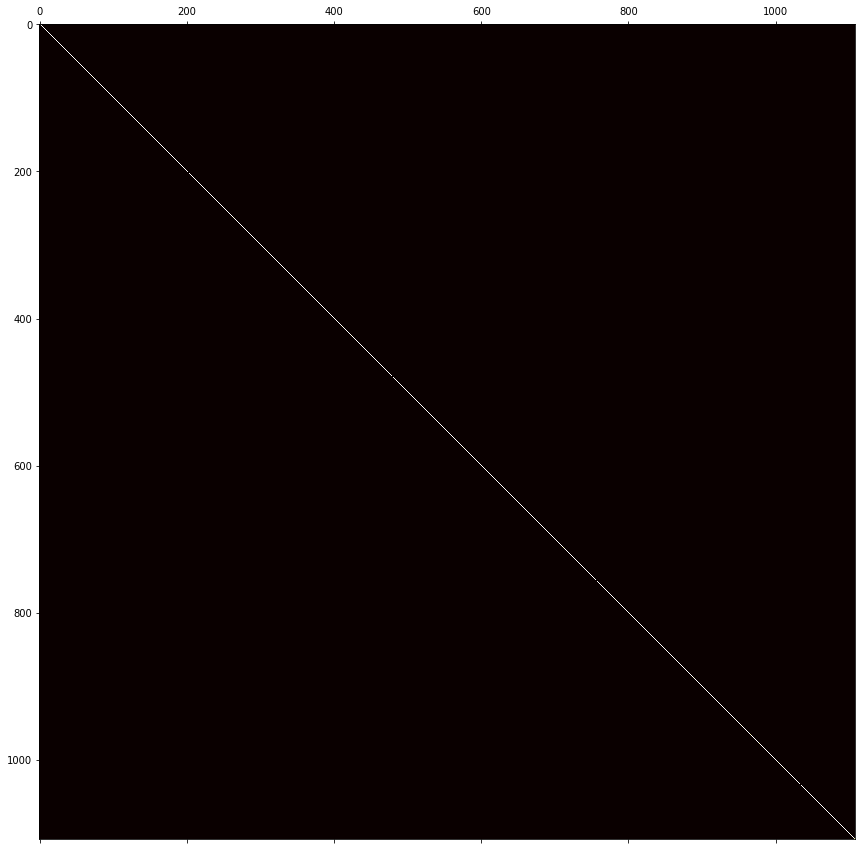

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [21]:
xq.max()

75.67511

In [22]:
faiss.normalize_L2(xq)

In [23]:
xq.max()

0.75922513

In [24]:
D_valid, I_valid = index.search(xq, k) # actual search

In [25]:
xq.shape, yq.shape

((15476, 512), (15476,))

In [26]:
I_valid.shape, D_valid.shape

((15476, 5), (15476, 5))

In [27]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[352 352 352 352 352]
 [544  11 862 544  11]
 [873 503  29   6 579]
 [505 505 505 505 505]
 [268 268  91  91 954]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.77948827 0.7728503  0.7673893  0.7124897  0.7108325 ]
 [0.671826   0.61505055 0.5894369  0.5815743  0.5713836 ]
 [0.6886748  0.6379383  0.60725236 0.57127416 0.5426463 ]
 [0.8660021  0.8566432  0.85624176 0.85158527 0.8510636 ]
 [0.71492326 0.7056601  0.6834022  0.68017864 0.6644677 ]]


In [28]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[611 124 238 982 647]
 [202 202 202 202 202]
 [824 824 824 824 824]
 [568 568 568 568 568]
 [680 680 509 509 509]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.7834339  0.723359   0.7159574  0.7121787  0.69626   ]
 [0.6305014  0.59941745 0.5811651  0.5710991  0.5644569 ]
 [0.77832234 0.6956382  0.6906208  0.68488765 0.68050575]
 [0.6906769  0.56534433 0.555922   0.54717535 0.5453795 ]
 [0.67177135 0.6131096  0.5522264  0.54473984 0.53667545]]


In [29]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [30]:
I_valid[:,0]

array([352, 544, 873, ..., 824, 568, 680])

In [31]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [32]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

7302

In [33]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.4718273455673301

In [34]:
valid_correct = np.equal(I_valid[:,0], yq)

In [35]:
valid_correct

array([ True, False, False, ...,  True, False, False])

In [36]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [37]:
cm = confusion_matrix(I_valid[:,0], yq)

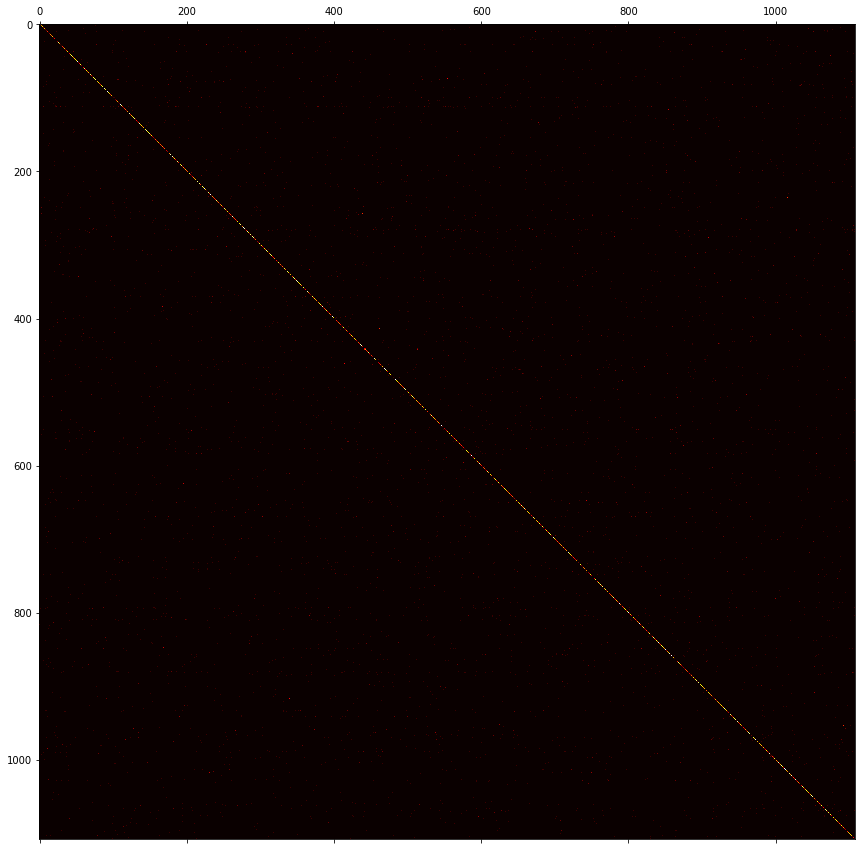

In [38]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [39]:
xq_test = np.load('pred/feats_test.npy')

In [40]:
xq_test.max()

151.00403

In [41]:
faiss.normalize_L2(xq_test)

In [42]:
xq_test.max()

0.770749

In [43]:
D_test, I_test = index.search(xq_test, k) # actual search

In [44]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [45]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[ 381  381  381  381  381]
 [ 265  265  248  248  265]
 [ 123  123  123  123  123]
 [1032 1032 1032 1032 1032]
 [ 585  989  555  159  555]]
[[0.7323102  0.6797011  0.65321773 0.61481094 0.5962484 ]
 [0.5264919  0.50618124 0.50259805 0.4880362  0.47591555]
 [0.53877306 0.5111685  0.5073274  0.5058165  0.503685  ]
 [0.57925457 0.5582092  0.54879636 0.5347439  0.53232944]
 [0.6910128  0.6720264  0.67057633 0.6664928  0.6614046 ]]


In [46]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[1011 1011 1011 1011  948]
 [ 316  316  316  316  316]
 [ 232  232  232  232  232]
 [1026 1026 1026 1026 1026]
 [1084 1084 1084 1084 1084]]
[[0.5271379  0.509401   0.5031692  0.50262237 0.49579394]
 [0.68256116 0.6806201  0.6725864  0.6676824  0.66224927]
 [0.6208192  0.6045009  0.59674454 0.59665465 0.58194435]
 [0.56807774 0.56468135 0.541461   0.53458035 0.52293193]
 [0.43864435 0.3978113  0.39412007 0.38656312 0.36441293]]


In [47]:
I_test[2]

array([123, 123, 123, 123, 123])

In [48]:
np.unique(I_test[2], return_counts=True)

(array([123]), array([5]))

In [49]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [50]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)